# Graph classification

Some dataset comes with intrinsic values that can be used as filtrations, e.g., graphs, medical images, molecules. Multiparameter persistence is then very well suited to deal will all of this information **at once**. To bring this to light, we will consider the BZR graph dataset. It can be found [here](https://networkrepository.com/BZR.php).

In [1]:
import multipers.data.graphs as mdg
import multipers.ml.signed_measures as mms
import networkx as nx
from random import choice
from os.path import expanduser
dataset = "graphs/BZR"
path = mdg.DATASET_PATH+dataset
!ls $path ## We assume that the dataset is in this folder. You can modify the variable `mdg.DATASET_PATH` if necessary

BZR.edges      BZR.graph_labels  BZR.node_labels  graphs.pkl  readme.html
BZR.graph_idx  BZR.node_attrs	 BZR.readme	  labels.pkl


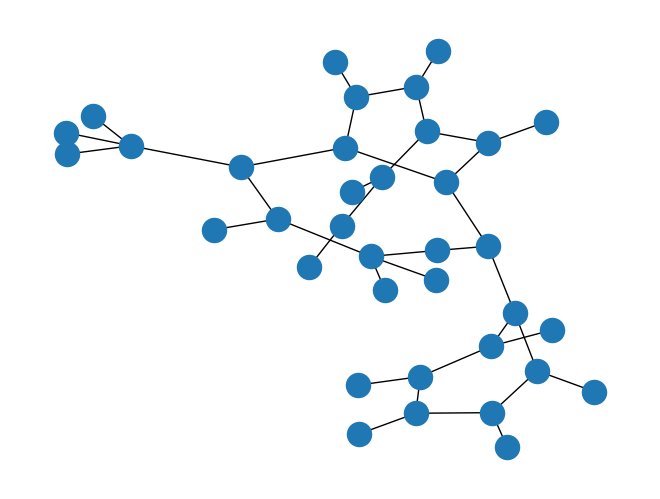

In [2]:
graphs, labels = mdg.get_graphs(dataset)
nx.draw(choice(graphs))

Graph dataset can be filtered by several filtration : node degrees, intrinsic values, ricci curvature, closeness centrality, heat kernel signature, etc.

In [3]:
# mdg.reset_graphs(dataset=dataset) # Enforce graph to be read from file

Reading graphs from file: 100%|██████████| 405/405 [01:21<00:00,  4.99it/s]


In [5]:
filtrations = ["hks_10","degree","geodesic", "cc"]
for f in filtrations:
    mdg.compute_filtration(dataset, filtration=f)
graphs, labels = mdg.get_graphs(dataset) # Retrieves these filtrations
g = graphs[0] # First graph of the dataset
g.nodes[0] # First node of the dataset, which holds several filtrations

Computing cc: 100%|██████████| 405/405 [00:00<00:00, 1301.14it/s]


{'intrinsic': array([-2.626347,  2.492403,  0.061623]),
 'hks_10': np.float64(0.13721841042259394),
 'degree': 0.3333333333333333,
 'geodesic': 0,
 'cc': 0.2116788321167883}

Similarly to the point clouds, we can create simplextrees, and turn them into signed measures

In [6]:
simplextrees = mdg.Graph2SimplexTrees(filtrations=filtrations).fit_transform(graphs)

In [7]:
signed_measures = mms.SimplexTrees2SignedMeasures(
	degrees=[None], n_jobs=1, grid_strategy='exact', enforce_null_mass=True
).fit_transform(simplextrees) # None correspond to the euler characteristic, which is significantly faster to compute on graphs. 
# One may want to rescale filtrations w.r.t. each other. This can be done using the SignedMeasureFormatter class
signed_measures = mms.SignedMeasureFormatter(normalize=True, axis=0).fit_transform(signed_measures)

And finally classify these graphs using either a sliced wasserstein kernel, or a convolution.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from multipers.ml.kernels import DistanceMatrix2Kernel
## Split the data into train test
xtrain,xtest,ytrain,ytest = train_test_split(signed_measures, labels)
## Classification pipeline using the sliced wasserstein kernel
classifier = Pipeline([
    ("SWD",mms.SignedMeasure2SlicedWassersteinDistance(n_jobs=-1, num_directions=50)),
    ("KERNEL", DistanceMatrix2Kernel(sigma=1.)),
    ("SVM", SVC(kernel="precomputed")),
])
## Evaluates the classifier on this dataset. 
# Note that there is no cross validation here, so results can be significantly improved
classifier.fit(xtrain,ytrain).score(xtest,ytest)

0.8921568627450981